# CSE252C: Homework 1
## Computing Resources
Please read the README file of this repository for the instructions
## Instructions
1. Attempt all questions.
2. Please comment all your code adequately.
3. Include all relevant information such as text answers, output images in notebook.
4. **Academic integrity:** The homework must be completed individually.

5. **Submission instructions:**  
 (a) Submit the notebook and its PDF version on Gradescope.  
 (b) Rename your submission files as Lastname_Firstname.ipynb and Lastname_Firstname.pdf.  
 (c) Correctly select pages for each answer on Gradescope to allow proper grading.

6. **Due date:** Assignments are due Mon, May 4, by 4pm PST.

## Question 1: Warm Up

We will first try SFM using the original implementation from $\mathtt{libviso2}$[8],[9]. We will test on a dataset containing 300 images from one sequence of the KITTI dataset with ground-truth camera poses and camera calibration information. 

Run the SFM algorithm using the following script. You are required to report two error metrics. The error metric for rotation is defined as the mean of Frobenius norm of the difference between the ground-truth rotation matrix and predicted rotation matrix. The error metric for translation is defined as mean of the L2 distance. Both errors will be printed on the screen as you run the code.  **(5 points)**

In [1]:
import os
import sys
# change your base path
os.chdir('./pyviso/') # './'
print(os.getcwd())

/home/sgaba/sfm/pyviso


In [2]:
import os
import numpy as np
import pandas as pd
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
import viso2
import matplotlib.pyplot as plt
from skimage.io import imread
import time

def errorMetric(RPred, RGt, TPred, TGt):
    diffRot = (RPred - RGt)
    diffTrans = (TPred - TGt)
    errorRot = np.sqrt(np.sum(np.multiply(diffRot.reshape(-1), diffRot.reshape(-1))))
    errorTrans = np.sqrt(np.sum(np.multiply(diffTrans.reshape(-1), diffTrans.reshape(-1))))

    return errorRot, errorTrans

if_vis = False # set to True to do the visualization per frame; the images will be saved at '.vis/'. Turn off if you just want the camera poses and errors
if_on_screen = False # if True the visualization per frame is going to be displayed realtime on screen; if False there will be no display, but in both options the images will be saved

# parameter settings (for an example, please download
# dataset_path = '../dataset_SfM/'
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM' # On the ``ieng6.ucsd.edu`` server
img_dir      = os.path.join(dataset_path, 'sequences/00/image_0')
gt_dir       = os.path.join(dataset_path, 'poses/00.txt')
calibFile    = os.path.join(dataset_path, 'sequences/00/calib.txt')
border       = 50;
gap          = 15;

# Load the camera calibration information
with open(calibFile) as fid:
    calibLines = fid.readlines()
    calibLines = [calibLine.strip() for calibLine in calibLines]

calibInfo = [float(calibStr) for calibStr in calibLines[0].split(' ')[1:]]
# param = {'f': calibInfo[0], 'cu': calibInfo[2], 'cv': calibInfo[6]}

# Load the ground-truth depth and rotation
with open(gt_dir) as fid:
    gtTr = [[float(TrStr) for TrStr in line.strip().split(' ')] for line in fid.readlines()]
gtTr = np.asarray(gtTr).reshape(-1, 3, 4)

# param['height'] = 1.6
# param['pitch']  = -0.08
# param['match'] = {'pre_step_size': 64}
first_frame  = 0
last_frame   = 300
epi = 1e-8

# init visual odometry
params = viso2.Mono_parameters()
params.calib.f = calibInfo[0]
params.calib.cu = calibInfo[2]
params.calib.cv = calibInfo[6]
params.height = 1.6
params.pitch = -0.08


first_frame  = 0
last_frame   = 300

# init transformation matrix array
Tr_total = []
Tr_total_np = []
Tr_total.append(viso2.Matrix_eye(4))
Tr_total_np.append(np.eye(4))

# init viso module
visoMono = viso2.VisualOdometryMono(params)

if if_vis:
    save_path = 'vis'
    os.makedirs(save_path, exist_ok=True)

    # create figure
    fig = plt.figure(figsize=(10, 15))
    ax1 = plt.subplot(211)
    ax1.axis('off')
    ax2 = plt.subplot(212)
    ax2.set_xticks(np.arange(-100, 100, step=10))
    ax2.set_yticks(np.arange(-500, 500, step=10))
    ax2.axis('equal')
    ax2.grid()
    if if_on_screen:
        plt.ion()
    else:
        plt.ioff()

In [15]:
# for all frames do
if_replace = False
errorTransSum = 0
errorRotSum = 0
errorRot_list = []
errorTrans_list =[]

#initialize an empty df to report errors
errors_df = pd.DataFrame(columns = ["Mean Rotation Error","Mean Transition Error"])

for frame in range(first_frame, last_frame):
#     break
    # 1-based index
    k = frame-first_frame+1

    # read current images
    I = imread(os.path.join(img_dir, '%06d.png'%frame))
    assert(len(I.shape) == 2) # should be grayscale

    # compute egomotion
    process_result = visoMono.process_frame(I, if_replace)
    Tr = visoMono.getMotion()
    matrixer = viso2.Matrix(Tr)
    Tr_np = np.zeros((4, 4))
    Tr.toNumpy(Tr_np) # so awkward...

    # accumulate egomotion, starting with second frame
    if k > 1:
        if process_result is False:
            if_replace = True
            Tr_total.append(Tr_total[-1])
            Tr_total_np.append(Tr_total_np[-1])
        else:
            if_replace = False
            Tr_total.append(Tr_total[-1] * viso2.Matrix_inv(Tr))
            Tr_total_np.append(Tr_total_np[-1] @ np.linalg.inv(Tr_np)) # should be the same
            print(Tr_total_np[-1])

    # output statistics
    num_matches = visoMono.getNumberOfMatches()
    num_inliers = visoMono.getNumberOfInliers()
    matches = visoMono.getMatches()
    matches_np = np.empty([4, matches.size()])

    for i,m in enumerate(matches):
        matches_np[:, i] = (m.u1p, m.v1p, m.u1c, m.v1c)

    if if_vis:
        # update image
        ax1.clear()
        ax1.imshow(I, cmap='gray', vmin=0, vmax=255)
        if num_matches != 0:
            for n in range(num_matches):
                ax1.plot([matches_np[0, n], matches_np[2, n]], [matches_np[1, n], matches_np[3, n]])
        ax1.set_title('Frame %d'%frame)

        # update trajectory
        if k > 1:
            ax2.plot([Tr_total_np[k-2][0, 3], Tr_total_np[k-1][0, 3]], \
                [Tr_total_np[k-2][2, 3], Tr_total_np[k-1][2, 3]], 'b.-', linewidth=1)
            ax2.plot([gtTr[k-2][0, 3], gtTr[k-1][0, 3]], \
                [gtTr[k-2][2, 3], gtTr[k-1][2, 3]], 'r.-', linewidth=1)
        ax2.set_title('Blue: estimated trajectory; Red: ground truth trejectory')

        plt.draw()

    # Compute rotation
    Rpred_p = Tr_total_np[k-2][0:3, 0:3]
    Rpred_c = Tr_total_np[k-1][0:3, 0:3]
    Rpred = Rpred_c.transpose() @ Rpred_p
    Rgt_p = np.squeeze(gtTr[k-2, 0:3, 0:3])
    Rgt_c = np.squeeze(gtTr[k-1, 0:3, 0:3])
    Rgt = Rgt_c.transpose() @ Rgt_p
    # Compute translation
    Tpred_p = Tr_total_np[k-2][0:3, 3:4]
    Tpred_c = Tr_total_np[k-1][0:3, 3:4]
    Tpred = Tpred_c - Tpred_p
    Tgt_p = gtTr[k-2, 0:3, 3:4]
    Tgt_c = gtTr[k-1, 0:3, 3:4]
    Tgt = Tgt_c - Tgt_p
    # Compute errors
    errorRot, errorTrans = errorMetric(Rpred, Rgt, Tpred, Tgt)
    errorRotSum = errorRotSum + errorRot
    errorTransSum = errorTransSum + errorTrans
    # errorRot_list.append(errorRot)
    # errorTrans_list.append(errorTrans)
    meanRotError = errorRotSum / (k-1+epi)
    meanTransError = errorTransSum / (k-1+epi)
    print('Mean Error Rotation: %.5f'%(meanRotError))
    print('Mean Error Translation: %.5f'%(meanTransError))

    errors_df.loc[len(errors_df)] = [meanRotError,meanTransError]

    print('== [Result] Frame: %d, Matches %d, Inliers: %.2f'%(frame, num_matches, 100*num_inliers/(num_matches+1e-8)))

    if if_vis:
        # input('Paused; Press Enter to continue') # Option 1: Manually pause and resume
        if if_on_screen:
            plt.pause(0.1) # Or Option 2: enable to this to auto pause for a while after daring to enable animation in case of a delay in drawing
        vis_path = os.path.join(save_path, 'frame%03d.jpg'%frame)
        fig.savefig(vis_path)
        print('Saved at %s'%vis_path)
        
        if frame % 50 == 0 or frame == last_frame-1:
            plt.figure(figsize=(10, 15))
            plt.imshow(plt.imread(vis_path))
            plt.axis('off')
            plt.show()


# input('Press Enter to exit')

Mean Error Rotation: 6947558.55240
Mean Error Translation: 9718750861.05217
== [Result] Frame: 0, Matches 0, Inliers: 0.00
[[ 1.     -0.0027 -0.0031 -0.0032]
 [ 0.0027  1.     -0.0026  0.0011]
 [ 0.0031  0.0026  1.      0.4828]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07468
Mean Error Translation: 97.56708
== [Result] Frame: 1, Matches 320, Inliers: 86.87
[[ 1.     -0.0022 -0.0078 -0.0051]
 [ 0.0022  1.     -0.0041 -0.0018]
 [ 0.0078  0.0041  1.      0.9579]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.03918
Mean Error Translation: 48.97651
== [Result] Frame: 2, Matches 325, Inliers: 81.23
[[ 0.9999 -0.0057 -0.014   0.0024]
 [ 0.0056  1.     -0.0053 -0.0075]
 [ 0.014   0.0052  0.9999  1.4471]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02883
Mean Error Translation: 32.77574
== [Result] Frame: 3, Matches 329, Inliers: 82.67
[[ 0.9998 -0.0058 -0.0197 -0.0071]
 [ 0.0057  1.     -0.006  -0.0118]
 [ 0.0197  0.0059  0.9998  1.9428]
 [ 0.      0.

[[ 0.998  -0.0077 -0.0633 -1.22  ]
 [ 0.0078  1.      0.0007 -0.2615]
 [ 0.0633 -0.0011  0.998  21.3241]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00492
Mean Error Translation: 3.06549
== [Result] Frame: 35, Matches 277, Inliers: 75.81
[[ 0.9977 -0.0166 -0.0652 -1.2517]
 [ 0.0166  0.9999  0.0003 -0.272 ]
 [ 0.0652 -0.0014  0.9979 22.0132]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00484
Mean Error Translation: 2.98841
== [Result] Frame: 36, Matches 276, Inliers: 75.72
[[ 0.9976 -0.0194 -0.067  -1.2884]
 [ 0.0192  0.9998 -0.0036 -0.2803]
 [ 0.067   0.0023  0.9977 22.6424]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00473
Mean Error Translation: 2.91712
== [Result] Frame: 37, Matches 257, Inliers: 76.26
[[ 0.9974 -0.0203 -0.0689 -1.3331]
 [ 0.0198  0.9998 -0.0076 -0.2896]
 [ 0.069   0.0062  0.9976 23.314 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00467
Mean Error Translation: 2.84859
== [Result] Frame: 38, Matches 280, Inl

[[ 0.9947 -0.0124 -0.1016 -3.2725]
 [ 0.0117  0.9999 -0.0072 -0.6218]
 [ 0.1017  0.006   0.9948 45.5155]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00335
Mean Error Translation: 1.67616
== [Result] Frame: 70, Matches 295, Inliers: 81.69
[[ 0.9947 -0.0088 -0.1027 -3.3537]
 [ 0.0082  0.9999 -0.0066 -0.6346]
 [ 0.1027  0.0057  0.9947 46.1659]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00335
Mean Error Translation: 1.65544
== [Result] Frame: 71, Matches 283, Inliers: 79.15
[[ 0.9943 -0.0102 -0.1057 -3.4096]
 [ 0.0096  0.9999 -0.0059 -0.6526]
 [ 0.1058  0.0048  0.9944 46.8083]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00337
Mean Error Translation: 1.63524
== [Result] Frame: 72, Matches 294, Inliers: 80.27
[[ 0.994  -0.0107 -0.109  -3.4609]
 [ 0.0102  0.9999 -0.0052 -0.6745]
 [ 0.109   0.0041  0.994  47.45  ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00335
Mean Error Translation: 1.61541
== [Result] Frame: 73, Matches 272, Inl

[[ 0.9631 -0.0423  0.2659 -4.0492]
 [ 0.0427  0.9991  0.0045 -0.9628]
 [-0.2658  0.007   0.964  60.4066]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00322
Mean Error Translation: 1.18879
== [Result] Frame: 103, Matches 342, Inliers: 85.67
[[ 0.9461 -0.0455  0.3206 -3.9106]
 [ 0.0461  0.9989  0.0057 -0.969 ]
 [-0.3205  0.0094  0.9472 60.6805]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00323
Mean Error Translation: 1.17822
== [Result] Frame: 104, Matches 338, Inliers: 86.98
[[ 0.9245 -0.0446  0.3785 -3.7691]
 [ 0.0453  0.9989  0.0071 -0.9652]
 [-0.3784  0.0106  0.9256 60.9488]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00322
Mean Error Translation: 1.16798
== [Result] Frame: 105, Matches 339, Inliers: 89.09
[[ 0.8991 -0.0475  0.4352 -3.5921]
 [ 0.0489  0.9988  0.0079 -0.9601]
 [-0.435   0.0142  0.9003 61.1965]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00324
Mean Error Translation: 1.15784
== [Result] Frame: 106, Matches 329,

[[ 0.114  -0.0509  0.9922 10.9458]
 [ 0.0841  0.9956  0.0414 -0.4011]
 [-0.9899  0.0787  0.1178 65.4445]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00315
Mean Error Translation: 0.94174
== [Result] Frame: 137, Matches 304, Inliers: 75.99
[[ 0.1109 -0.0509  0.9925 11.393 ]
 [ 0.0852  0.9955  0.0415 -0.3829]
 [-0.9902  0.0799  0.1148 65.4957]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00314
Mean Error Translation: 0.93623
== [Result] Frame: 138, Matches 308, Inliers: 74.68
[[ 0.1076 -0.0515  0.9929 11.865 ]
 [ 0.0864  0.9954  0.0423 -0.3659]
 [-0.9904  0.0812  0.1115 65.5495]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00312
Mean Error Translation: 0.93077
== [Result] Frame: 139, Matches 320, Inliers: 79.37
[[ 0.105  -0.0521  0.9931 12.3497]
 [ 0.0881  0.9952  0.0429 -0.3465]
 [-0.9906  0.083   0.1091 65.6011]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00311
Mean Error Translation: 0.92541
== [Result] Frame: 140, Matches 316,

[[ 0.0698 -0.0534  0.9961 31.9733]
 [ 0.0592  0.997   0.0493  0.2371]
 [-0.9958  0.0555  0.0727 68.179 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00300
Mean Error Translation: 0.79867
== [Result] Frame: 170, Matches 315, Inliers: 76.83
[[ 0.0589 -0.0527  0.9969 33.1178]
 [ 0.0581  0.9971  0.0493  0.2813]
 [-0.9966  0.055   0.0618 68.2457]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00299
Mean Error Translation: 0.79622
== [Result] Frame: 171, Matches 299, Inliers: 75.25
[[ 0.049  -0.0526  0.9974 34.3206]
 [ 0.0601  0.997   0.0496  0.3115]
 [-0.997   0.0575  0.052  68.2787]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00300
Mean Error Translation: 0.79411
== [Result] Frame: 172, Matches 289, Inliers: 69.90
[[ 0.038  -0.0511  0.998  36.3549]
 [ 0.058   0.9971  0.0488  0.3915]
 [-0.9976  0.056   0.0409 68.3663]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00299
Mean Error Translation: 0.79688
== [Result] Frame: 173, Matches 270,

[[ 0.5155 -0.0431  0.8558 52.0087]
 [ 0.0661  0.9978  0.0105  0.8748]
 [-0.8544  0.0512  0.5172 69.8034]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00288
Mean Error Translation: 0.70962
== [Result] Frame: 203, Matches 332, Inliers: 83.43
[[ 0.5693 -0.0391  0.8212 52.2627]
 [ 0.0676  0.9977  0.0006  0.8671]
 [-0.8193  0.0551  0.5707 70.048 ]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00289
Mean Error Translation: 0.70685
== [Result] Frame: 204, Matches 319, Inliers: 76.49
[[ 0.6226 -0.0335  0.7818 52.5002]
 [ 0.0636  0.9979 -0.0078  0.8617]
 [-0.7799  0.0546  0.6235 70.3122]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00289
Mean Error Translation: 0.70400
== [Result] Frame: 205, Matches 309, Inliers: 76.70
[[ 0.6732 -0.0282  0.7389 52.7132]
 [ 0.0583  0.9982 -0.015   0.8559]
 [-0.7371  0.0532  0.6737 70.5853]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00290
Mean Error Translation: 0.70129
== [Result] Frame: 206, Matches 309,

[[ 0.981  -0.0032  0.1942 55.5926]
 [ 0.0121  0.9989 -0.0444  0.3421]
 [-0.1938  0.0459  0.98   84.1253]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00285
Mean Error Translation: 0.62963
== [Result] Frame: 236, Matches 304, Inliers: 79.28
[[ 0.9815  0.0005  0.1917 55.732 ]
 [ 0.0089  0.9988 -0.0482  0.3105]
 [-0.1915  0.049   0.9803 84.8923]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00284
Mean Error Translation: 0.62739
== [Result] Frame: 237, Matches 290, Inliers: 72.41
[[ 0.9818  0.0007  0.1898 55.8785]
 [ 0.0078  0.999  -0.0439  0.2686]
 [-0.1897  0.0446  0.9808 85.7779]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00284
Mean Error Translation: 0.62559
== [Result] Frame: 238, Matches 266, Inliers: 73.31
[[ 0.9822 -0.0044  0.1877 55.9968]
 [ 0.0116  0.9992 -0.037   0.2459]
 [-0.1874  0.0386  0.9815 86.3603]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.00284
Mean Error Translation: 0.62355
== [Result] Frame: 239, Matches 279,

[[  0.9822   0.0083   0.1874  59.5592]
 [ -0.0053   0.9998  -0.0166  -0.8434]
 [ -0.1876   0.0154   0.9821 107.3336]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00280
Mean Error Translation: 0.57749
== [Result] Frame: 269, Matches 275, Inliers: 76.73
[[  0.9822   0.0141   0.1872  59.6785]
 [ -0.0102   0.9997  -0.0221  -0.8793]
 [ -0.1875   0.0198   0.9821 108.0339]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00281
Mean Error Translation: 0.57586
== [Result] Frame: 270, Matches 272, Inliers: 79.41
[[  0.9821   0.0237   0.1869  59.7971]
 [ -0.0168   0.9991  -0.0387  -0.9092]
 [ -0.1877   0.0349   0.9816 108.8956]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00281
Mean Error Translation: 0.57412
== [Result] Frame: 271, Matches 269, Inliers: 76.95
[[  0.9822   0.0251   0.186   59.9211]
 [ -0.0168   0.9988  -0.046   -0.9451]
 [ -0.1869   0.0421   0.9815 109.5773]
 [  0.       0.       0.       1.    ]]
Mean Error Rotation: 0.00281
Mean

1. Report the final rotation and translation error. **(2 points)**

``report two error metrics over all frames here``

Final Frame Rotation and Translation Error are 2.769420e-03 and 5.372061e-01 respectively.

In [27]:
print("Rotation and Transition Error metric for all frames \n")
errors_df.index = np.arange(1, len(errors_df) + 1)
errors_df.index.name = "Frame Number"
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(errors_df)

Rotation and Transition Error metric for all frames 

              Mean Rotation Error  Mean Transition Error
Frame Number                                            
1                    6.947559e+06           9.718751e+09
2                    7.467504e-02           9.756708e+01
3                    3.918372e-02           4.897651e+01
4                    2.883138e-02           3.277574e+01
5                    2.292990e-02           2.467299e+01
6                    1.901414e-02           1.981189e+01
7                    1.662314e-02           1.657085e+01
8                    1.492242e-02           1.425277e+01
9                    1.369252e-02           1.251394e+01
10                   1.287022e-02           1.115695e+01
11                   1.215395e-02           1.007173e+01
12                   1.120361e-02           9.182782e+00
13                   1.041973e-02           8.440186e+00
14                   1.018683e-02           7.811839e+00
15                   9.694304e-03 

Then answer the questions below

2. In $\mathtt{libviso2}$, the feature points are "bucketed" ($\mathtt{src/matcher.cpp: Line 285 - 326}$), which means in a certain area of region, the number of detected keypoint pairs should be within certain bounds. Why?  **(3 points)**

``answer here``
* For Coresspondence? to check of they are in certain closeness to epipolar line?. IDK

3. We have run SFM on a single camera, which means the scale of translation is unknown. However, as you may have observed, the predicted trajectory is still somehow similar to the ground-truth trajectory. How does $\mathtt{libviso2}$ handle this ambiguity ($\mathtt{viso\_mono.cpp: Line 245}$)?  **(5 points)**

* For SFM on a single camera or monocular vision, $\mathtt{libviso2}$ uses 8 point algorithm for fundamental matrix computation. For estimating the scale, it assumes that the camera is moving at a known and fixed height over ground. It computes the scaling factor by the ratio of estimated height and actual height(known). $\mathtt{libviso2}$ scales all the estimations with this scaling factor to handle monocular vision scale ambiguity.

4. Briefly explain the RANSAC algorithm used in $\mathtt{libviso2}$ ($\mathtt{viso\_mono.cpp: Line 113 - 129}$).  **(5 points)**

For "param.ransac_iters" times: <br>
– Randomly pick 8 correspondences across two images <br>
– Compute Fundamental Matrix($ F $) using these 8 correspondences <br>
– Among all correspondences, count number of inliers with $x^TFx$ less than 'param.inlier_threshold' <br>

Pick the Fundamental Matrix with the largest number of inliers <br>

## Question 2: Using SIFT [4] for SFM

In the second task, you are required to use keypoints and feature descriptors from SIFT for SFM. The SIFT implementation can be found in directory $\mathtt{SIFT}$. 

(A) Go to $\mathtt{SIFT}$ directory and run $\mathtt{runSIFT.py}$ (e.g. `python runSIFT.py --input /datasets/cse152-252-sp20-public/dataset_SfM/sequences/00/image_0/`). You will save the detected keypoints and feature descriptors under the directory $\mathtt{SIFT}$. For image $\mathtt{000abc.png}$, the pre-computed features and keypoints should be saved in a $\mathtt{.npy}$ file named as $\mathtt{000abc\_feature.npy}$. The variable should be a $130 \times N$ matrix with $\mathtt{single}$ precision, where $N$ is the number of feature points being detected. For each $130$-dimensional feature vector, the first two dimensions are the location of the keypoints (column number first and then row number) on the image plane and the last $128$ dimensions are the feature descriptor. 

(B) Run the following script

In [2]:
import runFeature
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'SIFT'
errors_df = runFeature.runSFM(dataset_path, feature_dir )

Mean Error Rotation: 694755855.23999
Mean Error Translation: 97187508610.52167
== [Result] Frame: 0, Matches 0, Inliers: 0.00
[[ 1.     -0.0028 -0.0035 -0.0003]
 [ 0.0028  1.     -0.0022 -0.0034]
 [ 0.0035  0.0022  1.      0.4718]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07478
Mean Error Translation: 97.57803
== [Result] Frame: 1, Matches 282, Inliers: 81.21
[[ 1.     -0.0015 -0.0074 -0.0079]
 [ 0.0015  1.     -0.0036 -0.0068]
 [ 0.0074  0.0036  1.      0.9191]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.03881
Mean Error Translation: 48.99547
== [Result] Frame: 2, Matches 281, Inliers: 74.38
[[ 0.9999 -0.0022 -0.0118 -0.0123]
 [ 0.0021  1.     -0.0051 -0.0093]
 [ 0.0118  0.0051  0.9999  1.3818]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02713
Mean Error Translation: 32.79668
== [Result] Frame: 3, Matches 292, Inliers: 77.40
[[ 0.9998 -0.002  -0.0173 -0.0196]
 [ 0.0019  1.     -0.0058 -0.0135]
 [ 0.0173  0.0057  0.9998  1.8655]
 [ 0.     

1. Report the final rotation and translation error. **(2 points)**

``report two error metrics over all frames here``

In [6]:
print("Rotation and Transition Error metric for all frames \n")
errors_df.index = np.arange(1, len(errors_df) + 1)
errors_df.index.name = "Frame Number"
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(errors_df)

Rotation and Transition Error metric for all frames 

              Mean Rotation Error  Mean Transition Error
Frame Number                                            
1                    6.947559e+08           9.718751e+10
2                    7.478028e-02           9.757803e+01
3                    3.881296e-02           4.899547e+01
4                    2.712613e-02           3.279668e+01
5                    2.160034e-02           2.469172e+01
6                    1.869995e-02           1.982549e+01
7                    1.624067e-02           1.658028e+01
8                    1.483475e-02           1.426018e+01
9                    1.355708e-02           1.251873e+01
10                   1.272596e-02           1.116281e+01
11                   1.203258e-02           1.007678e+01


Next, answer the following questions:

2. Does SIFT yield higher accuracy than the original $\mathtt{libviso2}$? Why or why not? If not, can you suggest one possible way to improve? **(5 points)**

``answer here``

3. Explain how SIFT achieves invariance to 
       a. illumination
       b. rotation
       c. scale
 **(3 points)**

``answer here``

Normalize

## Question 3: Using SuperPoint[1] for SFM

Now you are required to use keypoints and feature descriptors from SuperPoint for SFM. The code for the trained model of this method can be found from the $\mathtt{SuperPoint}$.

(A) Go to $\mathtt{SuperPoint}$ directory and run $\mathtt{demo\_superpoint.py}$.`python demo_superpoint.py --input /datasets/cse152-252-sp20-public/dataset_SfM/sequences/00/image_0/ --cuda` The detected keypoints and feature descriptors are under the directory $\mathtt{SuperPoint}$. The file format is similar to the SIFT case. For image $\mathtt{000abc.png}$, the pre-computed features and keypoints should be saved in a $\mathtt{.npy}$ file named as $\mathtt{000abc\_feature.npy}$. The variable is a $258\times N$ matrix with $\mathtt{single}$ precision, where $N$ is the number of feature points being detected. For each $258$-dimensional feature vector, the first two dimensions are the locations of the keypoint (column number first and then row number) on the image plane and the last $256$ dimensions represent the feature descriptor. 

(B) Run the following script

In [3]:
import runFeature
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'SuperPoint'
errors_df=runFeature.runSFM(dataset_path, feature_dir )

Mean Error Rotation: 694755855.23999
Mean Error Translation: 97187508610.52167
== [Result] Frame: 0, Matches 0, Inliers: 0.00
[[ 1.     -0.0058 -0.0049  0.017 ]
 [ 0.0058  1.     -0.0023 -0.0053]
 [ 0.0049  0.0023  1.      0.4936]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.07938
Mean Error Translation: 97.55885
== [Result] Frame: 1, Matches 294, Inliers: 69.39
[[ 1.     -0.0028 -0.0094  0.0112]
 [ 0.0028  1.     -0.0039 -0.0062]
 [ 0.0095  0.0039  0.9999  0.9888]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.04216
Mean Error Translation: 48.96231
== [Result] Frame: 2, Matches 303, Inliers: 77.56
[[ 0.9999 -0.0028 -0.012  -0.0239]
 [ 0.0028  1.     -0.0057 -0.0083]
 [ 0.012   0.0056  0.9999  1.8073]
 [ 0.      0.      0.      1.    ]]
Mean Error Rotation: 0.02853
Mean Error Translation: 32.65804
== [Result] Frame: 3, Matches 312, Inliers: 77.24
[[ 0.9999 -0.0016 -0.0161 -0.0611]
 [ 0.0015  1.     -0.0061 -0.0213]
 [ 0.0161  0.0061  0.9999  2.845 ]
 [ 0.     

,Mean Rotation Error,Mean Transition Error
0,6.947559e+08,9.718751e+10
1,7.937948e-02,9.755885e+01
2,4.216018e-02,4.896231e+01
3,2.852604e-02,3.265804e+01
4,2.219158e-02,2.453877e+01
5,1.849220e-02,1.969827e+01
6,1.599496e-02,1.647280e+01
7,1.457344e-02,1.416688e+01
8,1.342337e-02,1.243579e+01
9,1.283102e-02,1.108672e+01


1. Report the final rotation and translation error. **(2 points)**

``report two error metrics over all frames here``

In [6]:
print("Rotation and Transition Error metric for all frames \n")
errors_df.index = np.arange(1, len(errors_df) + 1)
errors_df.index.name = "Frame Number"
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(errors_df)

Rotation and Transition Error metric for all frames 

              Mean Rotation Error  Mean Transition Error
Frame Number                                            
1                    6.947559e+08           9.718751e+10
2                    7.478028e-02           9.757803e+01
3                    3.881296e-02           4.899547e+01
4                    2.712613e-02           3.279668e+01
5                    2.160034e-02           2.469172e+01
6                    1.869995e-02           1.982549e+01
7                    1.624067e-02           1.658028e+01
8                    1.483475e-02           1.426018e+01
9                    1.355708e-02           1.251873e+01
10                   1.272596e-02           1.116281e+01
11                   1.203258e-02           1.007678e+01


Next, answer the following questions:

2. Does SuperPoint yield higher accuracy than the original $\mathtt{libviso2}$? If so, why? If not, what steps can you take to improve? **(5 points)**

``answer here``

3. Explain briefly how the following issues are being handled in SuperPoint: **(3 points)**
       a. Obtaining ground truth for keypoints.
       b. Cheaply obtaining accurate ground truth matches, as compared to LIDAR in UCN or SFM in LIFT.
       c. Learning a correlated feature representation for keypoint detection and description? 

``answer here``

## Question 4: Using SPyNet [5] for SFM

Now we will compute camera motion from optical flow computed using SPyNet. We first uniformly sample points in an image, then consider the flow-displaced point in the other image as a match. A modified PyTorch implementation of SPyNet is provided in directory  $\mathtt{Flow}$.

(A) Go to $\mathtt{Flow}$ and run $\mathtt{demo\_spynet.py}$. 

(B) Run the following script.

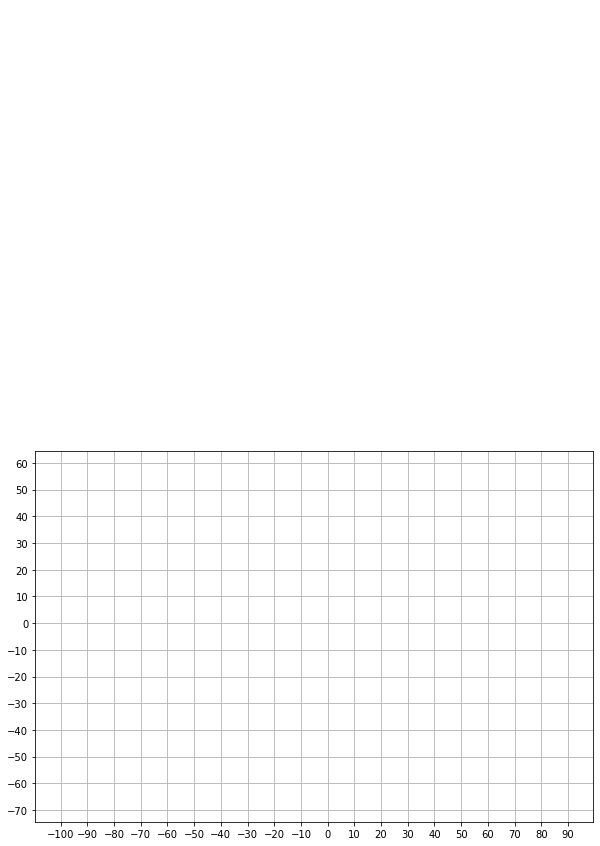

Mean Error Rotation: inf
Mean Error Translation: inf
== [Result] Frame: 0, Matches 0, Inliers: 0.00


/home/sgaba/sfm/pyviso/runMatch.py:203: RuntimeWarning: divide by zero encountered in double_scalars
  print('Mean Error Rotation: %.5f'%(errorRotSum / (k-1)))
/home/sgaba/sfm/pyviso/runMatch.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  print('Mean Error Translation: %.5f'%(errorTransSum / (k-1)))


<Figure size 432x288 with 0 Axes>

Saved at vis_preFeature/frame000.jpg


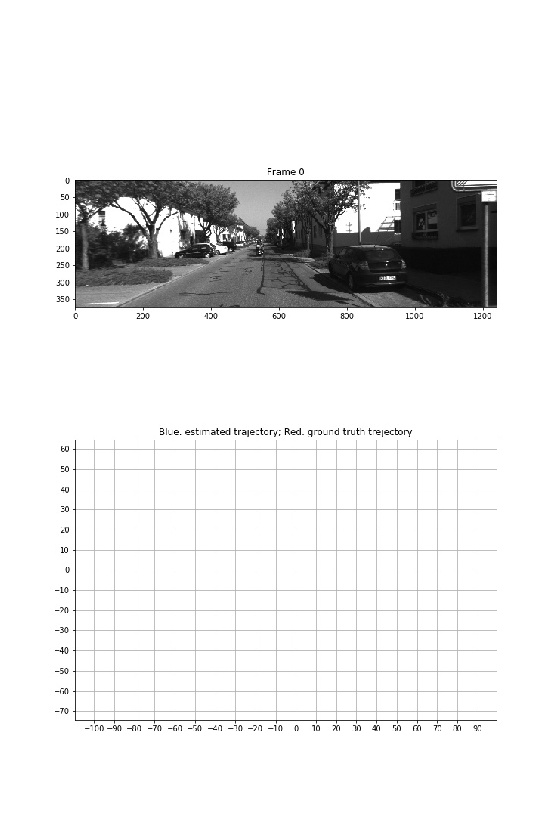

FileNotFoundError: [Errno 2] No such file or directory: 'Flow/000001_flow.npy'

In [3]:
import runMatch
dataset_path = '/datasets/cse152-252-sp20-public/dataset_SfM'
feature_dir = 'Flow'
runMatch.runSFM(dataset_path, feature_dir )

1. Report the final rotation and translation error. **(2 points)**

``report two error metrics over all frames here``

Next, answer the following questions:

2. Does SPyNet yield higher accuracy than the original $\mathtt{libviso2}$? Why or why not? If not, what steps can you take to improve? **(5 points)**

``answer here``

3. Explain how SPyNet achieves accurate flow with significantly lower computational cost. **(3 points)**

``answer here``

Basic goal: learn a CNN Gk to predict residual flow at each level

Each level solves a simple problem, so each level Gk can have simple architecture

## Question 5: Using Sfm-learner for SFM
Now we will use deep neural networks for SFM. Please follow the open-source Sfmlearner repository (https://github.com/ClementPinard/SfmLearner-Pytorch) and the paper (https://people.eecs.berkeley.edu/~tinghuiz/projects/SfMLearner/cvpr17_sfm_final.pdf) to answer the following questions.

1. Describe how photometric loss is implemented in Sfmlearner? Please refer to the paper and the code. **(5 points)**

``answer here``

2. Train the model and show the training curve, validation curve, and visualization of predicted depth and warped images? Which loss is decreasing and which is increasing? Why? **(10 points)**

 Visualize the specific images: `val_Depth_Output_Normalized/0`, `val_Warped_Outputs/0` from tensorboard.
 
 Training data: 
`/datasets/cse152-252-sp20-public/sfmlearner_h128w416`.

#### Install the environment
`pip install -r requirements.txt`
- fix scipy version problem: 

`pip install scipy==1.1.0 --user`

#### Training script
`cd SfmLearner-Pytorch`

`python3 train.py /datasets/cse152-252-sp20-public/sfmlearner_h128w416 -b4 -m0.2 -s0.1 --epoch-size 3000 --sequence-length 3 --log-output`




``answer here``

3. When training the model, we use 3 consecutive frames. Now, you will use the photometric consistency between the 1st and the 3rd frame. To be more specific, you can get the pose $T_{1,3} = T_{2,3} @ T_{1,2}$, where $T_{1,2}, T_{2,3}$ have already been computed in the original code. Add the constraint to the total loss and report the results in the same manner as in part 2 above. **(10 points)**

``answer here``

4. Now, you will evaluate your models from parts (2), (3) on the KITTI odometry dataset. What are the error metrics used in Sfm-learner? Please report the `ATE` and `RE` for sequence `09` and `10`. **(5 points)**

  Data: `/datasets/cse152-252-sp20-public/kitti`.

#### Evaluation script
`python3 test_pose.py /path/to/posenet --dataset-dir /datasets/cse152-252-sp20-public/kitti --sequences 09`

``answer here``

### Notes:
- scp data to local machines:

`scp -r <USERNAME>@dsmlp-login.ucsd.edu:/datasets/cse152-252-sp20-public/sfmlearner_h128w416.zip`

`scp -r <USERNAME>@dsmlp-login.ucsd.edu:/datasets/cse152-252-sp20-public/kitti.zip`
...
- tensorboard: open jupyter notebook from the link after `launch-scipy-ml-gpu.sh`. Click new `Tensorboard ..`

# References
1. Daniel DeTone, Tomasz Malisiewicz, and Andrew Rabinovich. Superpoint: Self-supervised interest point detection and description. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition Workshops, pages 224–236, 2018.
2. Andreas Geiger, Philip Lenz, and Raquel Urtasun. Are we ready for autonomous driving? the kitti vision benchmark suite. In Conference on Computer Vision and Pattern Recognition (CVPR), 2012.
3. Andreas Geiger, Julius Ziegler, and Christoph Stiller. Stereoscan: Dense 3d reconstruction in real-time. In Intelligent Vehicles Symposium (IV), 2011.
4. David G Lowe. Distinctive image features from scale-invariant keypoints. IJCV, 60(2):91–110, 2004.
5. Anurag Ranjan and Michael J Black. Optical flow estimation using a spatial pyramid network. In
Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pages 4161–4170, 2017.
6. A. Vedaldi and B. Fulkerson. VLFeat: An open and portable library of computer vision algorithms. http://www.vlfeat.org/, 2008.
7. Lucas, Bruce D., and Takeo Kanade. "An iterative image registration technique with an application to stereo vision." (1981): 674.
8. B. Kitt, A. Geiger, and H. Lategahn, “Visual odometry based on stereo image sequences with RANSAC-based outlier rejection scheme,” in 2010 IEEE Intelligent Vehicles Symposium, La Jolla, CA, USA, Jun. 2010, pp. 486–492, doi: 10.1109/IVS.2010.5548123.
9. A. Geiger, J. Ziegler, and C. Stiller, “StereoScan: Dense 3d reconstruction in real-time,” in 2011 IEEE Intelligent Vehicles Symposium (IV), Baden-Baden, Germany, Jun. 2011, pp. 963–968, doi: 10.1109/IVS.2011.5940405.